In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")
print(df.shape)

(51648, 20)


In [3]:
def seperate_column_to_days(col):
    days = []
    col = col.to_numpy()
    for i in range(0,len(col), 24):
        days.append(col[i:i+24])
    
    # The list goes 12 hours further in time than what it should
    # Thus removes the last 13 hours from 
    # 2021-11-24 12:00:00+01:00 - 2021-11-25 00:00:00+01:00
    #days.pop()

    # The list includes data split into entire days
    # from 2016-01-03 12:00:00+01:00 - 2021-11-24 11:00:00+01:00
    return days

days = seperate_column_to_days(df['NO2_price'])

# Creating datasets of days
What I want is to create individual sequences of days, the idea is to use 72 hours to create 3 days, which can then be used to predict further on in time

In [4]:
no_hours = 8*24 # lookbehind + one horizon
hour_in_days = int(no_hours / 24)

dataset = []
for i in range(len(days)-hour_in_days+1):
    dataset.append(np.concatenate((days[i:i+hour_in_days])))

dataset = np.array(dataset)

In [5]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_absolute_error(Y_true[:,-1], Y_pred[:,-1])

In [6]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [7]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
dataset = dataset[..., np.newaxis].astype(np.float32)

n,m,k = dataset.shape
print(n,m,k)

n_steps = m - 24
horizon = 24

2145 192 1


In [8]:
train = int(0.7*n)
valid = int(0.9*n)
#train = int(0.9*n)

# (7000 time series, 50 steps each)
X_train, y_train = dataset[:train, :n_steps], dataset[:train, -horizon:, 0]
X_valid, y_valid = dataset[train:valid, :n_steps], dataset[train:valid, -horizon: 0]
X_test, y_test = dataset[valid:, :n_steps], dataset[valid:, -horizon:, 0]
#X_test, y_test = dataset[train:, :n_steps], dataset[train:, -horizon:, 0]


# Seq - to - seq does not give satisfying results

Y = np.empty((n, n_steps, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset[:,step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]


print(f"{X_train.shape=}")
print(f"{X_valid.shape=}")
print(f"{X_test.shape=}")

X_train.shape=(1501, 168, 1)
X_valid.shape=(429, 168, 1)
X_test.shape=(215, 168, 1)


In [9]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(horizon)
])


model_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20)),
    keras.layers.Dense(horizon)
])

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(horizon)
])

"""
model_gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(horizon))
])
"""

2021-12-12 17:30:28.286741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-12 17:30:28.289862: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


'\nmodel_gru = keras.models.Sequential([\n    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),\n    keras.layers.GRU(20, return_sequences=True),\n    keras.layers.TimeDistributed(keras.layers.Dense(horizon))\n])\n'

In [ ]:
model.summary()
model_ln.summary()
model_lstm.summary()
#model_gru.summary()

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 5
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_ln.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_lstm.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
#model_gru.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs)#, validation_data=(X_valid, y_valid))

In [ ]:
history_ln = model_ln.fit(X_train, y_train, epochs=epochs)#, validation_data=(X_valid, y_valid))

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs)#, validation_data=(X_valid, y_valid))

In [ ]:
#history_gru = model_gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
Y_pred_ln = model_ln.predict(X_test)

In [ ]:
Y_pred_lstm = model_lstm.predict(X_test)

# Sequence to vector, with 24 outputs at final timestep

In [ ]:
x = np.arange(no_hours)
plt.figure(figsize=(15,10))
plt.plot(x[:no_hours-horizon], X_test[36,:].flatten(), '.-')
plt.plot(x[-horizon:], Y_pred[36].flatten(), '-.', label="SimpleRNN")
#plt.plot(x[-horizon:], Y_pred_ln[36].flatten(), '-.', label="LayerNorm")
#plt.plot(x[-horizon:], Y_pred_lstm[36].flatten(), '-.', label="LSTM")
plt.legend()
plt.grid()
plt.show()

# SEQ to SEQ plots
These are now corrected

In [9]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.SimpleRNN(64, return_sequences=True),
    #keras.layers.SimpleRNN(64, return_sequences=True),
    #keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.Dense(horizon, activation='leaky_relu')
])

model_lstm = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 1]),
    #keras.layers.LSTM(64, return_sequences=True),
    #keras.layers.LSTM(64, return_sequences=True),
    #keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dense(horizon, activation='leaky_relu')
])

model_gru = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, padding="valid", input_shape=[None, 1]),
    keras.layers.GRU(32, return_sequences=True),
    #keras.layers.GRU(64, return_sequences=True),
    #keras.layers.GRU(128, return_sequences=True),
    #keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dense(horizon, activation='leaky_relu')
])

2021-12-13 20:23:34.290916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-13 20:23:34.298761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-13 20:23:34.298780: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-13 20:23:34.299718: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
epochs = 10
model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_lstm.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
model_gru.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

In [11]:
model.summary()
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 32)          1088      
                                                                 
 dense (Dense)               (None, None, 24)          792       
                                                                 
Total params: 1,880
Trainable params: 1,880
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4352      
                                                                 
 dense_1 (Dense)             (None, None, 24)          792       
                                                                 
Total params: 5,144
Trainable pa

In [12]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/10
47/47 [==============================] - 3s 41ms/step - loss: 0.0085 - last_time_step_mse: 0.0652 - val_loss: 0.0025 - val_last_time_step_mse: 0.0320
Epoch 2/10
47/47 [==============================] - 2s 35ms/step - loss: 0.0027 - last_time_step_mse: 0.0369 - val_loss: 0.0018 - val_last_time_step_mse: 0.0238
Epoch 3/10
47/47 [==============================] - 2s 37ms/step - loss: 0.0015 - last_time_step_mse: 0.0300 - val_loss: 0.0016 - val_last_time_step_mse: 0.0206
Epoch 4/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0012 - last_time_step_mse: 0.0277 - val_loss: 0.0016 - val_last_time_step_mse: 0.0202
Epoch 5/10
47/47 [==============================] - 2s 36ms/step - loss: 9.5961e-04 - last_time_step_mse: 0.0231 - val_loss: 0.0016 - val_last_time_step_mse: 0.0197
Epoch 6/10
47/47 [==============================] - 2s 36ms/step - loss: 7.8954e-04 - last_time_step_mse: 0.0182 - val_loss: 0.0014 - val_last_time_step_mse: 0.0172
Epoch 7/10
47/47 [========

In [13]:
history_lstm = model_lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid))

Epoch 1/10
47/47 [==============================] - 5s 73ms/step - loss: 0.0109 - last_time_step_mse: 0.0719 - val_loss: 0.0029 - val_last_time_step_mse: 0.0361
Epoch 2/10
47/47 [==============================] - 3s 65ms/step - loss: 0.0032 - last_time_step_mse: 0.0452 - val_loss: 0.0028 - val_last_time_step_mse: 0.0361
Epoch 3/10
47/47 [==============================] - 3s 65ms/step - loss: 0.0030 - last_time_step_mse: 0.0428 - val_loss: 0.0031 - val_last_time_step_mse: 0.0391
Epoch 4/10
47/47 [==============================] - 3s 66ms/step - loss: 0.0027 - last_time_step_mse: 0.0388 - val_loss: 0.0030 - val_last_time_step_mse: 0.0347
Epoch 5/10
47/47 [==============================] - 3s 64ms/step - loss: 0.0023 - last_time_step_mse: 0.0337 - val_loss: 0.0029 - val_last_time_step_mse: 0.0328
Epoch 6/10
47/47 [==============================] - 3s 65ms/step - loss: 0.0019 - last_time_step_mse: 0.0307 - val_loss: 0.0027 - val_last_time_step_mse: 0.0320
Epoch 7/10
47/47 [================

In [14]:
history_gru = model_gru.fit(X_train, Y_train[:,3::2], epochs=epochs, validation_data=(X_valid, Y_valid[:,3::2]))

Epoch 1/10
47/47 [==============================] - 4s 47ms/step - loss: 0.0073 - last_time_step_mse: 0.0628 - val_loss: 0.0024 - val_last_time_step_mse: 0.0290
Epoch 2/10
47/47 [==============================] - 2s 41ms/step - loss: 0.0021 - last_time_step_mse: 0.0321 - val_loss: 0.0021 - val_last_time_step_mse: 0.0256
Epoch 3/10
47/47 [==============================] - 2s 40ms/step - loss: 0.0015 - last_time_step_mse: 0.0265 - val_loss: 0.0015 - val_last_time_step_mse: 0.0210
Epoch 4/10
47/47 [==============================] - 2s 38ms/step - loss: 0.0011 - last_time_step_mse: 0.0251 - val_loss: 0.0014 - val_last_time_step_mse: 0.0222
Epoch 5/10
47/47 [==============================] - 2s 38ms/step - loss: 9.1110e-04 - last_time_step_mse: 0.0229 - val_loss: 0.0014 - val_last_time_step_mse: 0.0230
Epoch 6/10
47/47 [==============================] - 2s 38ms/step - loss: 7.8014e-04 - last_time_step_mse: 0.0207 - val_loss: 0.0013 - val_last_time_step_mse: 0.0208
Epoch 7/10
47/47 [========

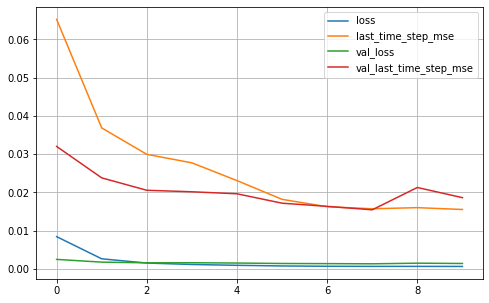

In [15]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

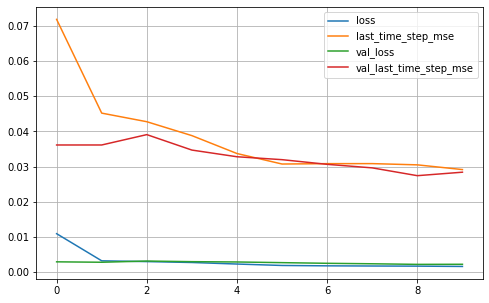

In [16]:
pd.DataFrame(history_lstm.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

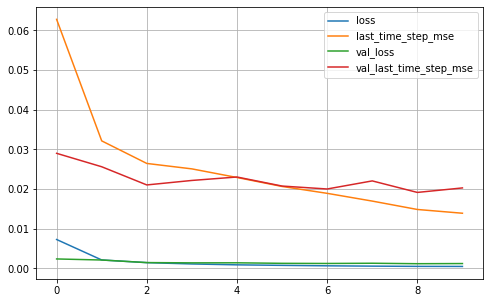

In [17]:
pd.DataFrame(history_gru.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(-0,0.06)
plt.show()

In [18]:
Y_pred = model.predict(X_test)
Y_pred_lstm = model_lstm.predict(X_test)
Y_pred_gru = model_gru.predict(X_test)

In [19]:
print(f"{MSE(Y_test[36,-1], Y_pred[36,-1])=}")
print(f"{MSE(Y_test[36,-1], Y_pred_lstm[36,-1])=}")
print(f"{MSE(Y_test[36,-1], Y_pred_gru[36,-1])=}")

MSE(Y_test[36,-1], Y_pred[36,-1])=0.005650002470305446
MSE(Y_test[36,-1], Y_pred_lstm[36,-1])=0.0070862042084725825
MSE(Y_test[36,-1], Y_pred_gru[36,-1])=0.008000517170455697


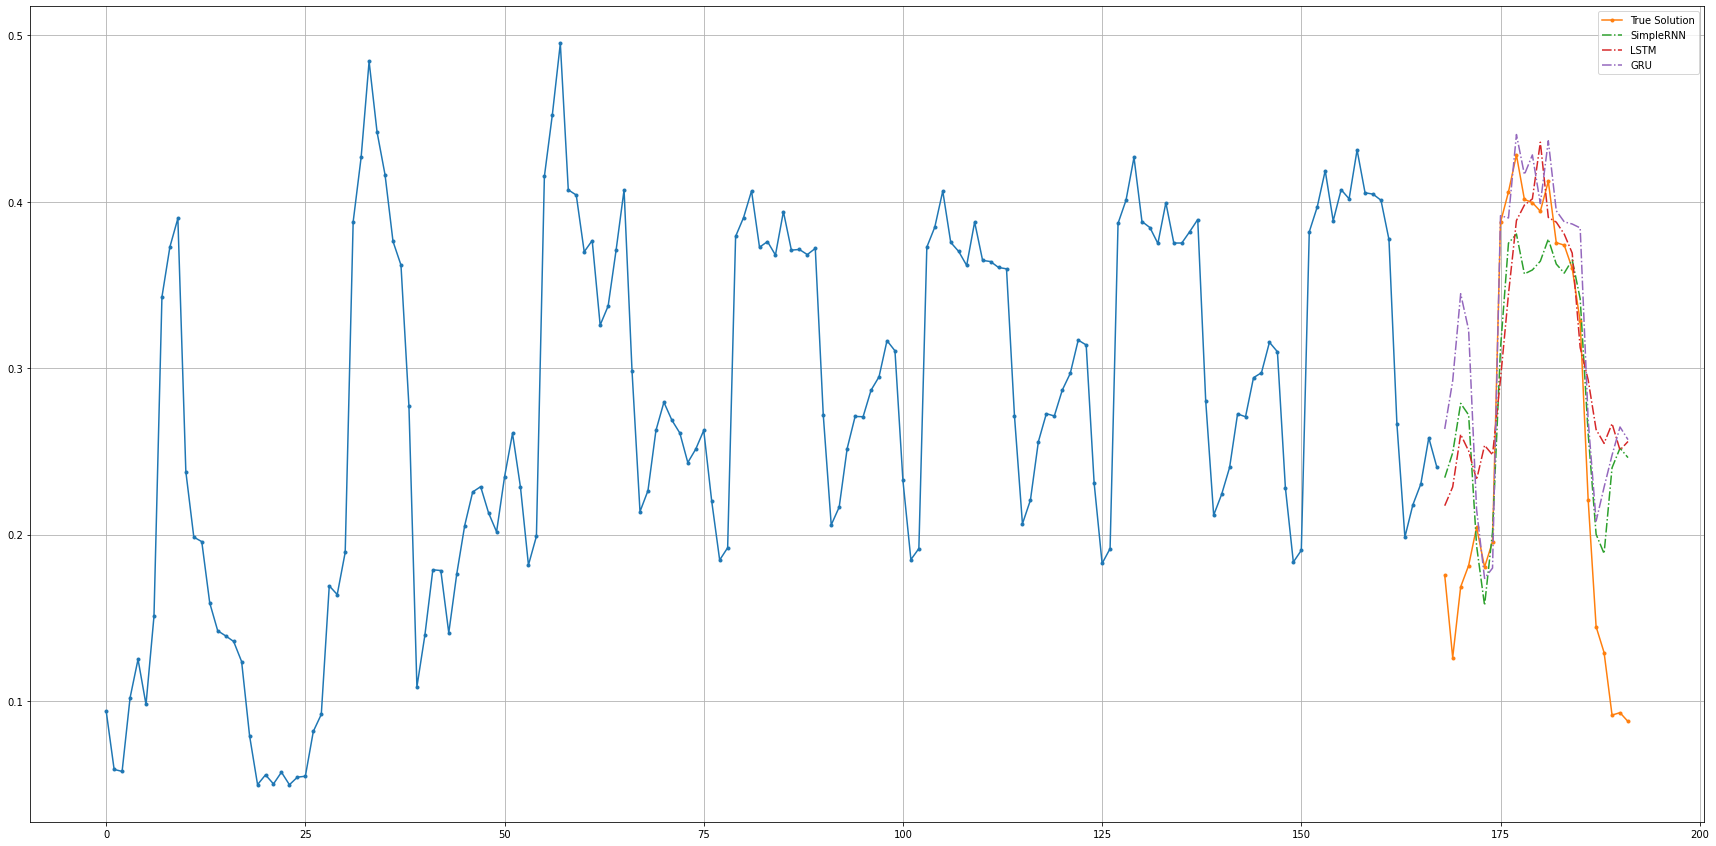

In [20]:
x = np.arange(no_hours)
plt.figure(figsize=(30,15))
plt.plot(x[:no_hours-horizon], X_test[36,:].flatten(), '.-')
plt.plot(x[-horizon:], Y_test[36,-1].flatten(), '.-', label="True Solution")
plt.plot(x[-horizon:], Y_pred[36,-1].flatten(), '-.', label="SimpleRNN")
plt.plot(x[-horizon:], Y_pred_lstm[36,-1].flatten(), '-.', label="LSTM")
plt.plot(x[-horizon:], Y_pred_gru[36,-1].flatten(), '-.', label="GRU")
plt.legend()
plt.grid()
plt.show()

In [21]:
"""
Y_pred = model.predict(X_test)
Y_pred_ln = model_ln.predict(X_test)
Y_pred_lstm = model_lstm.predict(X_test)
#Y_pred_gru = model_gru.predict(X_test)
"""

'\nY_pred = model.predict(X_test)\nY_pred_ln = model_ln.predict(X_test)\nY_pred_lstm = model_lstm.predict(X_test)\n#Y_pred_gru = model_gru.predict(X_test)\n'

In [22]:
"""
sequence = np.concatenate((X_test[0].flatten(), Y_pred[0,-1,:].flatten()))
sequence_ln = np.concatenate((X_test[0].flatten(), Y_pred_ln[0,-1,:].flatten()))
sequence_lstm = np.concatenate((X_test[0].flatten(), Y_pred_lstm[0,-1,:].flatten()))
#sequence_gru = np.concatenate((X_test[20].flatten(), Y_pred_gru[20,-horizon:,-1].flatten()))

x = np.arange(n_steps + horizon)
plt.figure(figsize=(15,10))
plt.plot(x[:n_steps], sequence[:n_steps], '.-')
plt.plot(x[n_steps-1:], sequence[n_steps-1:], '-.', label="SimpleRNN")
plt.plot(x[n_steps-1:], sequence_ln[n_steps-1:], '-.', label="Layer norm")
plt.plot(x[n_steps-1:], sequence_lstm[n_steps-1:], '-.', label="LSTM")
#plt.plot(x[n_steps-1:], sequence_gru[n_steps-1:], '-.', label="GRU")

plt.legend()
plt.grid()
plt.show()
"""

'\nsequence = np.concatenate((X_test[0].flatten(), Y_pred[0,-1,:].flatten()))\nsequence_ln = np.concatenate((X_test[0].flatten(), Y_pred_ln[0,-1,:].flatten()))\nsequence_lstm = np.concatenate((X_test[0].flatten(), Y_pred_lstm[0,-1,:].flatten()))\n#sequence_gru = np.concatenate((X_test[20].flatten(), Y_pred_gru[20,-horizon:,-1].flatten()))\n\nx = np.arange(n_steps + horizon)\nplt.figure(figsize=(15,10))\nplt.plot(x[:n_steps], sequence[:n_steps], \'.-\')\nplt.plot(x[n_steps-1:], sequence[n_steps-1:], \'-.\', label="SimpleRNN")\nplt.plot(x[n_steps-1:], sequence_ln[n_steps-1:], \'-.\', label="Layer norm")\nplt.plot(x[n_steps-1:], sequence_lstm[n_steps-1:], \'-.\', label="LSTM")\n#plt.plot(x[n_steps-1:], sequence_gru[n_steps-1:], \'-.\', label="GRU")\n\nplt.legend()\nplt.grid()\nplt.show()\n'

In [23]:
"""
fig = plt.figure()
x = np.arange(5*24)
plt.plot(x[:72],dataset[0],'--')
plt.plot(x[24:4*24],dataset[1],'--')
plt.plot(x[2*24:5*24],dataset[2],'--')
plt.xlabel("time")
plt.ylabel("price")
plt.grid()
plt.show
"""

'\nfig = plt.figure()\nx = np.arange(5*24)\nplt.plot(x[:72],dataset[0],\'--\')\nplt.plot(x[24:4*24],dataset[1],\'--\')\nplt.plot(x[2*24:5*24],dataset[2],\'--\')\nplt.xlabel("time")\nplt.ylabel("price")\nplt.grid()\nplt.show\n'